### Задание 5.1

У нас есть данные АА-теста с '2023-06-23' по '2023-06-29'. Нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

1. Построить гистограмму распределения получившихся 10000 p-values.

2. Посчитать, какой процент p values оказался меньше либо равен 0.05

3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

4. Пришлите ссылку на merge request c проведенным анализом.

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import seaborn as sns
from  scipy import stats
import pandahouse
from matplotlib import pyplot as plt

In [2]:
# Загружаем данные о количестве просмотров и лайков полизователей из 2 и 3 экспериментальной группы за период с 23 по 29 июня, считаем их CTR
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'******',
                      'user':'student', 
                      'password':'******'
                     }


query = """
    SELECT exp_group, 
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-06-23' and '2023-06-29'
        and exp_group in (2,3)
    GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(query, connection=connection)

# взглянем на количество пользователей в каждой группе
df.groupby('exp_group').user_id.count()

exp_group
2    8362
3    8425
Name: user_id, dtype: int64

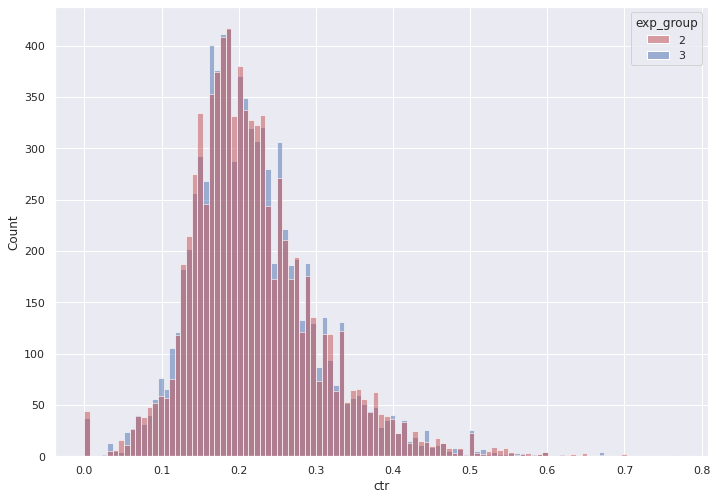

In [3]:
# Нарисуем распределение CTR в группах

sns.set(rc={'figure.figsize':(11.7,8.27)})
groups = sns.histplot(data = df,
              x='ctr',
              hue='exp_group',
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [4]:
# сравним группы целиком с помощью t-test
stats.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.6617303509169771, pvalue=0.5081531382926281)

Гистограмма CTR, построенная на основе всех данных, и сравнение групп t-testом, свидетельствуют о том, что группы не отличаются.
*****
#### Осуществим симуляцию 10 тыс А/А-тестов 

In [5]:
# 10000 раз извлечем выборки без повторений по 500 пользователей из каждой группы и сравним их t-testом. P-value каждого теста сохраним в список.
p_values = []
for i in range(10000):
    test = stats.ttest_ind(df[df.exp_group == 2].sample(500, replace = False).ctr
                          ,df[df.exp_group == 3].sample(500, replace = False).ctr
                          ,equal_var = False)
    p_values.append(test[1])

(0.0, 1.0)

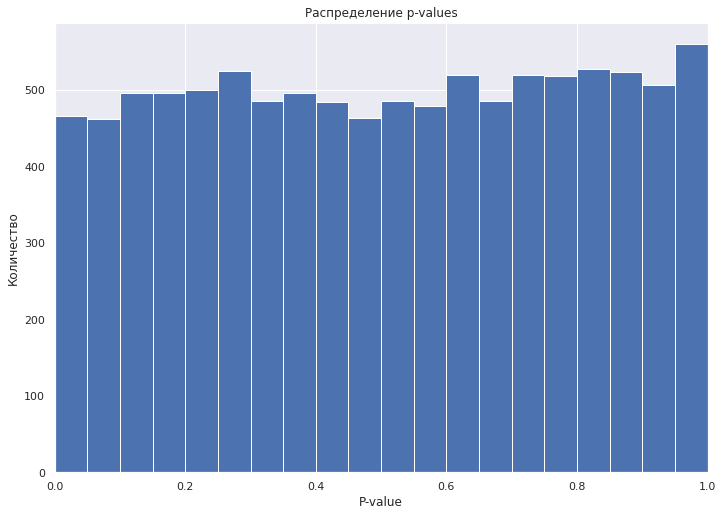

In [6]:
# Нарисуем гистограмму распределения 10 тысяч p-values

fig, axes = plt.subplots(ncols=1, nrows=1)
pd.Series(p_values).hist(bins = 20)
plt.xlabel("P-value")
plt.ylabel("Количество")
plt.title('Распределение p-values')
axes.set_xlim((0, 1))


In [7]:
# Посчитаем процент p value меньше или равно 0.05

print(f'{round(sum([i <= 0.05 for i in p_values]) / len(p_values) * 100, 2)}% \
p-values оказалось меньше или равно 0.05. Должно быть около 5%.')

4.66% p-values оказалось меньше или равно 0.05. Должно быть около 5%.


****
#### Вывод

1) Распределение p-values, полученное в результате сравнения с помощью t-test 10 тысяч выборок по 500 наблюдений из каждой группы, оказалось равномерным;

2) 4,66% p-values оказались меньше или равны 0.05.

**Оба факта свидетельствуют о том, что система сплитования работает корректно.**